Dropdown(options={'India': 'IND', 'Japan': 'JPN', 'China': 'CHN', 'Australia': 'AUS'}, value='IND')

<IPython.core.display.Javascript object>


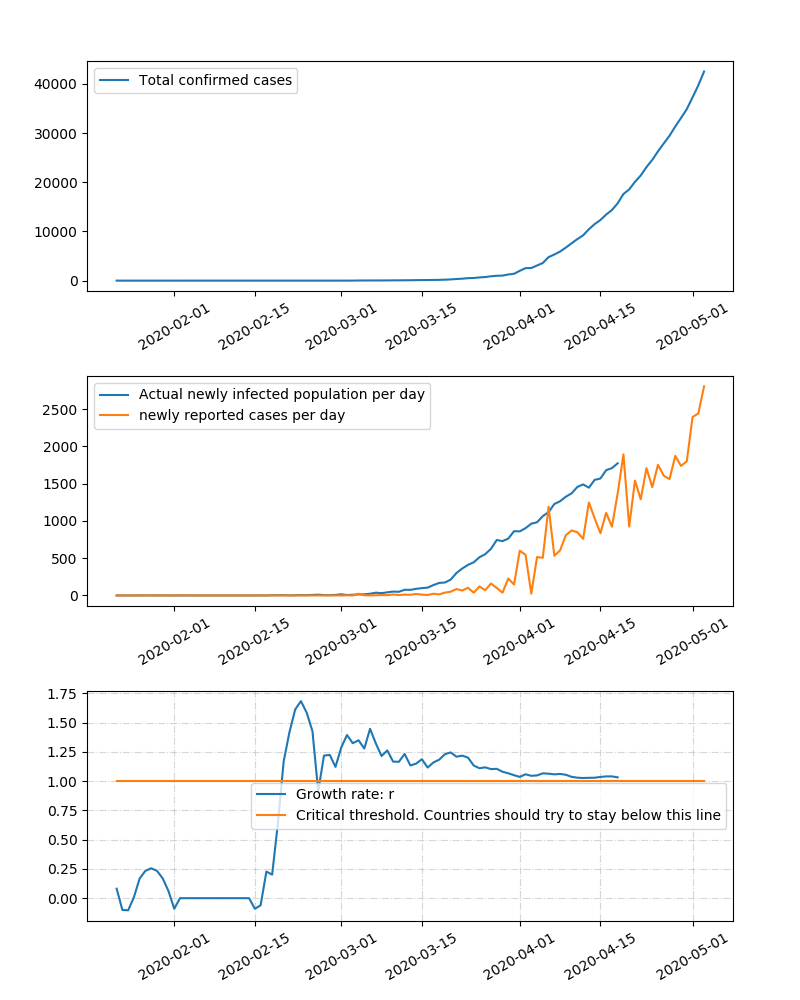

In [73]:
import requests,json,random,datetime
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import ipywidgets as widgets
from IPython.display import display
from scipy.signal import savgol_filter

def getData(BRA):
    url = 'https://covidapi.info/api/v1/country/BRA
    response = requests.get(url)
    if response.status_code==200:
        data= json.loads(response.content)['result']
        days=[{**data[d],'date':d} for d in data]# Merging two dicts
        return days
    else:
        return

def calculateNewReportedCases(days):
    newReportedCases=[0 for x in days]
    for i in range(len(days)):
        if i>0:
            newReportedCases[i]=days[i]['confirmed']-days[i-1]['confirmed']
    return newReportedCases

def calculateNewTrueCases(newReportedCases):
    newTrueCases=[0 for x in newReportedCases]
    mu, sigma = -10, 3
    cutoff=15 #only calculating till those dates, that would have led to cases being reported
    for i in range(len(newReportedCases)):
        dist = np.around(np.random.normal(mu, sigma, abs(newReportedCases[i])))# taking abs for taking of weird data that number of confirmed cases decreased
        dayOffsets, counts = np.unique(dist, return_counts=True)
        for j in range(len(dayOffsets)):
            dayOffset=dayOffsets[j]
            day=int(i+dayOffset)
            if(day>0 and day<(len(newReportedCases)-1)):
                if(newReportedCases[i]>0):
                    newTrueCases[day]+=counts[j]
                else:
                    newTrueCases[day]-=counts[j]# again for those negative values that come in some data.
    return newTrueCases[:-cutoff]

def calculateR(newTrueCases):
    """
    i = 0
    moving_averages = []
    window_size=5
    while i < len(newTrueCases) - window_size + 1:
        this_window = newTrueCases[i : i + window_size]
        window_average = sum(this_window) / window_size
        moving_averages.append(window_average)
        i += 1

    newTrueCases=moving_averages
    """
    r=[0 for x in newTrueCases]
    for i in range(1,len(newTrueCases)):
        if(newTrueCases[i-1]>0):
            r[i]=newTrueCases[i]/newTrueCases[i-1]
            #print("{} : {}".format(days[i+window_size]['date'],r[i]))
    return r
    

def plotGraphs(BRA):
    days=getData(BRA)
    if (not days):
        print('No data available for country')
    else:
        #dates=[day['date'] for day in days]
        dates = [datetime.datetime.strptime(day['date'],"%Y-%m-%d").date() for day in days]
        active=[day['confirmed']-day['recovered']-day['deaths'] for day in days]
        newReportedCases=calculateNewReportedCases(days)
        newTrueCases=calculateNewTrueCases(newReportedCases)
        #sNewTrueCases=savgol_filter(newTrueCases, 15, 3)#smoothing
        R=calculateR(newTrueCases)
        Rs = savgol_filter(R, 9, 3)#smoothing

        fig, graphs = plt.subplots(3, 1, figsize = (8, 10))
        fig.tight_layout(pad=4.0)
        formatter = mdates.DateFormatter("%Y-%m-%d")
        g1=graphs[0]
        g1.xaxis.set_major_formatter(formatter)
        plt.setp(g1.xaxis.get_majorticklabels(), rotation=30)
        g1.plot(dates,[day['confirmed'] for day in days],label='Total confirmed cases')
        g1.legend(loc='best')
        #g1.plot(active)

        g2 = graphs[1]
        g2.xaxis.set_major_formatter(formatter)
        plt.setp(g2.xaxis.get_majorticklabels(), rotation=30)
        g2.plot(dates[:len(newTrueCases)],newTrueCases,label='Actual newly infected population per day')
        g2.plot(dates,newReportedCases,label='newly reported cases per day')
        g2.legend(loc='best')

        g3 = graphs[2]
        #g3.plot(Rs)
        g3.xaxis.set_major_formatter(formatter)
        plt.setp(g3.xaxis.get_majorticklabels(), rotation=30)
        g3.plot(dates[:len(Rs)],Rs,label='Growth rate: r')
        g3.plot(dates,[1 for x in days],label='Critical threshold. Countries should try to stay below this line')
        g3.legend(loc='best')
        g3.grid(alpha=0.5, linestyle='-.')
        

countries={"India":"IND","Japan":"JPN","China":"CHN","Australia":"AUS"}
dd_country = widgets.Dropdown(options = countries)
display(dd_country)
plotGraphs('IND')
